In [1]:
import torch
import torchvision
from torch import nn
from torchvision.datasets import ImageFolder
from torchvision import transforms
import matplotlib.pyplot as plt

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
data_dir = "/content/drive/MyDrive/SSNE/data"

In [17]:
%%capture
!cp -r /content/drive/MyDrive/SSNE/data/train.zip /home/train.zip

In [27]:
%%capture
!cd /home/ && unzip /home/train.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/fish/n02599958_3516.JPEG  
  inflating: train/fish/n01482071_2215.JPEG  
  inflating: train/fish/n01316579_5225.JPEG  
  inflating: train/fish/n01316579_4592.JPEG  
  inflating: train/fish/n02599958_11059.JPEG  
  inflating: train/fish/n02600298_28037.JPEG  
  inflating: train/fish/n01482071_2947.JPEG  
  inflating: train/fish/n02600798_2674.JPEG  
  inflating: train/fish/n02599958_8965.JPEG  
  inflating: train/fish/n02600298_5377.JPEG  
  inflating: train/fish/n02599958_4089.JPEG  
  inflating: train/fish/n02599958_8258.JPEG  
  inflating: train/fish/n02599958_7841.JPEG  
  inflating: train/fish/n02600298_16468.JPEG  
  inflating: train/fish/n02599958_8104.JPEG  
  inflating: train/fish/n02599958_9214.JPEG  
  inflating: train/fish/n01316579_2225.JPEG  
  inflating: train/fish/n02600298_1866.JPEG  
  inflating: train/fish/n01482071_279.JPEG  
  inflating: train/fish/n02600298_2395.JPEG  
  inflating: train/fish/n02

In [30]:
train_dir = "train"

In [63]:
trainset = ImageFolder(train_dir, transform=torchvision.transforms.ToTensor())

In [ ]:
import matplotlib.pyplot as plt
from collections import Counter

class_counts = Counter(trainset.targets)

class_names = trainset.classes
class_distribution = {class_names[idx]: count for idx, count in class_counts.items()}

plt.figure(figsize=(10, 6))
plt.bar(class_distribution.keys(), class_distribution.values(), color='skyblue')
plt.xlabel('Class Names')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Trainset')
plt.xticks(rotation=60, ha='right')
plt.tight_layout()
plt.show()

In [65]:
from collections import defaultdict
from torch.utils.data import Subset
import random

class_indices = defaultdict(list)
for idx, (_, label) in enumerate(trainset):
    class_indices[label].append(idx)

subset_indices = []
for label, indices in class_indices.items():
    sample_size = max(1, int(0.05 * len(indices)))
    subset_indices.extend(random.sample(indices, sample_size))

balanced_subset = Subset(trainset, subset_indices)

In [66]:
balanced_subset

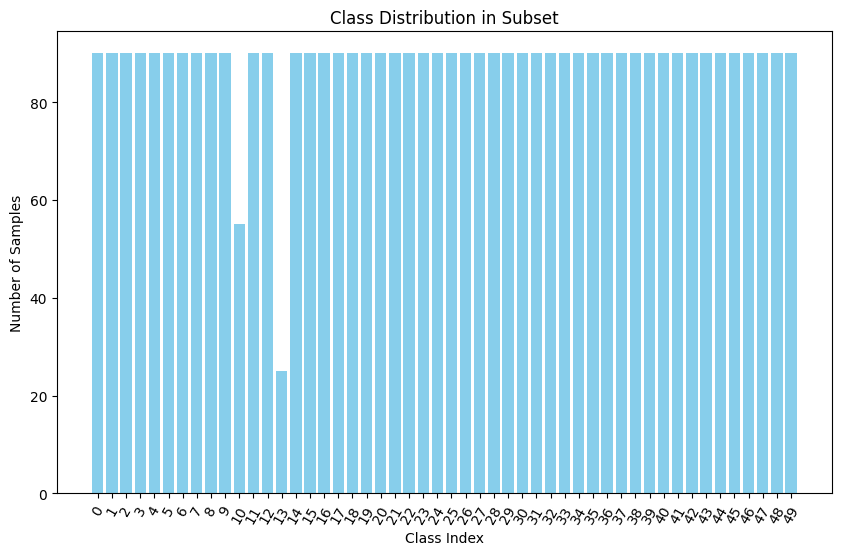

In [67]:
from collections import Counter


subset_labels = [trainset[idx][1] for idx in subset_indices]

class_counts = Counter(subset_labels)

plt.figure(figsize=(10, 6))
plt.bar(class_counts.keys(), class_counts.values(), color='skyblue')
plt.xlabel('Class Index')
plt.ylabel('Number of Samples')
plt.title('Class Distribution in Subset')
plt.xticks(range(len(class_counts.keys())), rotation=60)
plt.show()

In [68]:
def train_model(model, train_loader, criterion, optimizer, device, epochs=10):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

In [69]:
def evaluate_model(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = correct / total
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

In [70]:
def train(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    optimizer: torch.optim.Optimizer,
    loss_fn: torch.nn.Module,
    epochs: int,
    device: torch.device
):

  results: dict[str, list[float]] = {
      "Train_Loss": [],
      "Val_Loss": [],
      "Train_Accuracy": [],
      "Val_Accuracy": [],
  }

  for epoch in range(epochs):
    train_loss, train_accuracy = train_step(
        model=model,
        train_dataloader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        device=device,
    )

    val_loss, val_accuracy = test_step(
        model=model,
        test_dataloader=test_dataloader,
        loss_fn=loss_fn,
        device=device,
    )

    results["Train_Loss"].append(train_loss)
    results["Val_Loss"].append(val_loss)
    results["Train_Accuracy"].append(train_accuracy)
    results["Val_Accuracy"].append(val_accuracy)

  return results

In [71]:
def train_step(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    device: torch.device,
):
  model.train()
  total_loss = 0
  train_acc = 0
  correct = 0
  total = 0

  for batch, (inputs, targets) in enumerate(train_dataloader):
    inputs, targets = inputs.to(device), targets.to(device)
    optimizer.zero_grad()
    outputs = model(inputs)
    loss = loss_fn(outputs, targets)
    loss.backward()
    optimizer.step()

    total_loss += loss.item()
    _, predicted = torch.max(outputs, 1)
    total += targets.size(0)
    correct += (predicted == targets).sum().item()

  accuracy = correct / total
  total_loss /= len(train_dataloader)

  return total_loss, accuracy


In [72]:
def test_step(
    model: torch.nn.Module,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: torch.nn.Module,
    device: torch.device,
):
  model.eval()
  total_loss = 0
  correct = 0
  total = 0

  with torch.inference_mode():
    for batch, (inputs, targets) in enumerate(test_dataloader):
      inputs, targets = inputs.to(device), targets.to(device)
      outputs = model(inputs)
      loss = loss_fn(outputs, targets)
      total_loss += loss.item()

      _, predicted = torch.max(outputs, 1)
      total += targets.size(0)
      correct += (predicted == targets).sum().item()

  accuracy = correct / total
  total_loss /= len(test_dataloader)

  return total_loss

In [73]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

val_split = 0.2
train_size = int((1 - val_split) * len(balanced_subset))
val_size = len(balanced_subset) - train_size

train_subset, val_subset = random_split(balanced_subset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)

print(f"Liczba próbek w zbiorze treningowym: {len(train_subset)}")
print(f"Liczba próbek w zbiorze walidacyjnym: {len(val_subset)}")

Liczba próbek w zbiorze treningowym: 3520
Liczba próbek w zbiorze walidacyjnym: 880


In [74]:
from torchvision.models import resnet18
import torch.optim as optim
import torch.nn as nn
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = resnet18(weights='DEFAULT')
model.fc = nn.Linear(model.fc.in_features, len(trainset.classes))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 5

In [ ]:
train(model, train_loader, val_loader, optimizer, criterion, epochs, device)